# DC Power estimation

<table>
  <tr>
    <td><img src="logos/CSTB_logo.jpg" width="200" />
    <td><img src="logos/Heliocity_logo.png" width="200" /> 
    <td><img src="logos/USMB_logo_horizontal.png" width="200" />
  </tr>
</table>

<sub>Author: Alexandre MATHIEU, Phd Student, in collaboration Heliocity / CSTB / USMB (LOCIE). </sub>
<sub>Phd thesis: Methodology development to guarantee building photovoltaic systems' performance including failure modelling</sub>

This notebook introduces some tools to model the AC power production of a PV installation.

It is broken down into three parts:

1. **Data visualization**: Exploration of weather data
2. **POA irradiance, temperature, and Power modeling**: Estimation temperature/AC power and comparison to real values.
3. **Performance metric**: Calculation of the Performance Ratio and Energy Performance Index

The attendees are very much welcome to modify and create/execute some new notebook cells to explore data and try out new methods.

**Make sure to manually execute the cells (ctrl + enter) yourself one by one**

The measured data has been downloaded from the Scenario S1, Alburquerque USA, of the PVPMC blind comparison, 2021.

## 1. Data vizualization

In [1]:
# Please execute this cell to import packages
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

# Change the directory path to import functions from local modules
if not 'workbookDir' in globals():
    workbookDir = Path(os.getcwd()).parent
print('Work directory: ' + str(workbookDir))
os.chdir(workbookDir)

from src.config import DATA_PATH # Directory ROOT path
from src.utils.helio_fmt import setup_helio_plt
setup_helio_plt() # set plot format and font


Work directory: C:\Users\MATHIEU\OneDrive - CSTBGroup\Bureau\Code\pvfault_detection_solar_academy


## 1.1. In-situ weather data

Below is the weather inputs of the models to estimate the DC production.

In [2]:
# Load weather data: incident irradiation, direct irradiation, temperature, wind
weather_data = pd.read_csv(DATA_PATH / "xtrain.csv", index_col=0) 
weather_data.index = pd.to_datetime(weather_data.index)
print(weather_data.head(10))

                                  ghi        dhi         dni  temp_air  \
2020-01-01 01:00:00-07:00    0.000000   0.000000    0.000000  0.000000   
2020-01-01 02:00:00-07:00    0.000000   0.000000    0.000000  0.000000   
2020-01-01 03:00:00-07:00    0.000000   0.000000    0.000000  0.000000   
2020-01-01 04:00:00-07:00    0.000000   0.000000    0.000000  0.000000   
2020-01-01 05:00:00-07:00    0.000000   0.000000    0.000000  0.000000   
2020-01-01 06:00:00-07:00    0.000000   0.000000    0.000000  0.000000   
2020-01-01 07:00:00-07:00    0.000000   0.000000    0.000000  0.000000   
2020-01-01 08:00:00-07:00   40.874978  14.742914  264.832939 -4.737162   
2020-01-01 09:00:00-07:00  185.738601  31.546335  754.498236 -3.652383   
2020-01-01 10:00:00-07:00  353.666975  40.138926  914.471581 -0.708700   

                           wind_speed  sun_azimuth  sun_elevation  
2020-01-01 01:00:00-07:00    0.000000    45.887005     -73.699678  
2020-01-01 02:00:00-07:00    0.000000    60.33037

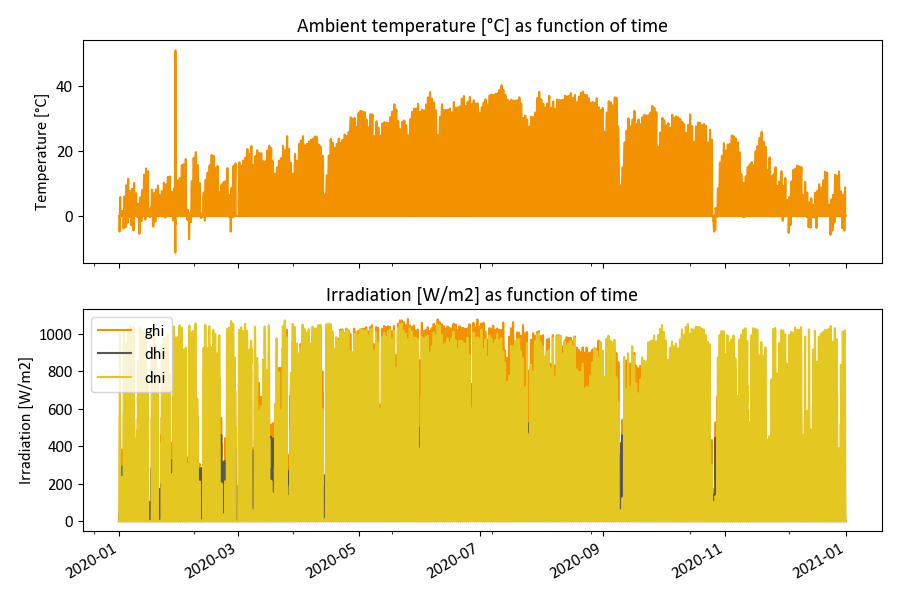

In [3]:
# Make the figure interactive and enable to zoom
%matplotlib widget 
# If the widget does not work, the line below switches to a regular figure
#%matplotlib inline 

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,6), sharex=True)
weather_data["temp_air"].plot(ax=ax1, title="Ambient temperature [°C] as function of time",ylabel="Temperature [°C]")
meteo_plot = weather_data[["ghi","dhi", "dni"]]
meteo_plot.plot(ax=ax2, title="Irradiation [W/m2] as function of time",ylabel="Irradiation [W/m2]")
plt.tight_layout()

## 2. DC power estimation

Modeling PV power from ghi/dhi/dni goes into three steps:

1. Modeling the POA irradiance.
2. Modeling the module cell temperature. 
3. Modeling the installation power production.
4. Modeling the installation inverter efficiency.


### 2.1. POA irradiance

In [4]:
# Installation orientation
beta = 35 # tilt [°]
azimuth = 180 # azimuth [°]
rho = 0.2

## <span style="color: red"> Exercice </span>

Calculate the POA irradiance with the no-shading/isotropic assumption as introduced in the notebook "python_intro_poa"

In [5]:
# The lazy way with the pvlib package
from pvlib.irradiance import get_total_irradiance

# Notice it takes degrees as inputs
poa_data = get_total_irradiance(beta, azimuth, 90-weather_data["sun_elevation"], weather_data["sun_azimuth"],
                                weather_data["dni"], weather_data["ghi"], weather_data["dhi"], albedo=rho)
poa_data.head(12)

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
2020-01-01 01:00:00-07:00,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 02:00:00-07:00,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 03:00:00-07:00,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 04:00:00-07:00,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 05:00:00-07:00,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 06:00:00-07:00,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 07:00:00-07:00,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 08:00:00-07:00,98.965639,84.816622,14.149017,13.409801,0.739216
2020-01-01 09:00:00-07:00,432.922776,400.869941,32.052835,28.693790,3.359045
2020-01-01 10:00:00-07:00,689.575320,646.669920,42.905400,36.509405,6.395995


### 2.2. Cell temperature model

The cell temperature can be modeled according to:

- Faiman model 
- Ross model

In [6]:
NOCT  = 43 # From datasheet

# Generic coefficients for open-rack PV installation from Faiman study (Faiman, D. (2008). “Assessing the outdoor operating temperature of photovoltaic modules.” Progress in Photovoltaics 16(4): 307-315.)
u_0 = 26.9 # W/(˚C.m2)
u_1 = 6.2 # W.s/(˚C.m3)

## <span style="color: red"> Exercice </span>

Calculate the module temperature with the Ross or Faiman model

In [7]:
t_mod = weather_data["temp_air"] + (43-20)/800 * poa_data["poa_global"]
t_mod2 = weather_data["temp_air"] +  poa_data["poa_global"] / (u_0 + u_1 * weather_data["wind_speed"])

### 2.3. DC power model

## <span style="color: red"> Exercice </span>

Calculate the DC power with the PVwatts or Huld model

In [8]:
Pdc_0 = 3900 #Wp Nominal power
gamma_pdc= -0.258 / 100 # [-]/°C

In [9]:
dc_power = Pdc_0 * poa_data["poa_global"] / 1000 * (1 + gamma_pdc * (t_mod2 - 25)) 

### 2.4. AC power model

## <span style="color: red"> Exercice </span>

Calculate the AC power with the PVWatts inverter model with the below function

<AxesSubplot:>

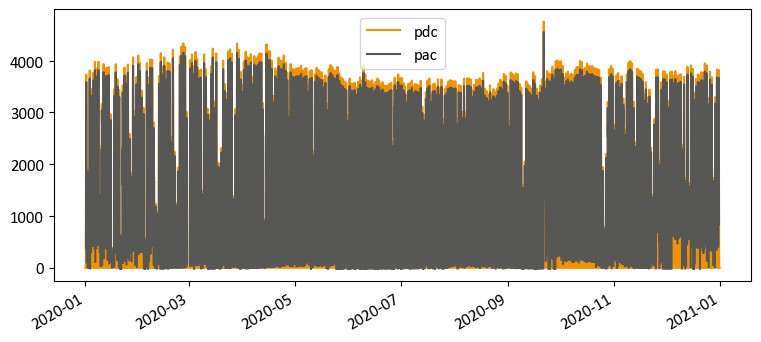

In [10]:
# Adapted from pvlib, 
def pvwatts_inverter(pdc, pdc0, eta_inv_nom=0.96, eta_inv_ref=0.9637):

    pac0 = eta_inv_nom * pdc0
    zeta = pdc / pdc0

    # Avoid to divide by 0 for array
    if type(zeta) is float:
        if zeta==0:
            zeta=np.nan
    else:
        zeta[zeta==0] = np.nan
    
    eta = eta_inv_nom / eta_inv_ref * (-0.0162 * zeta - 0.0059/zeta + 0.9858)

    power_ac = eta * pdc

    return power_ac
ac_power = pvwatts_inverter(dc_power, Pdc_0)

df = pd.DataFrame()
df["pdc"] = dc_power
df["pac"] = ac_power

# Make the figure interactive and enable to zoom
%matplotlib widget 
# If the widget does not work, the line below switches to a regular figure
%matplotlib inline  

df.plot(figsize=(9,4))

## 3. Performance Ratio calculation

In [11]:
# Load actual data
actual = pd.read_csv(DATA_PATH / "ytrain.csv", index_col=0) 
actual.index = pd.to_datetime(actual.index)
print(actual.head(10))

                                 gpoa      t_mod          pdc
2020-01-01 01:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 02:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 03:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 04:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 05:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 06:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 07:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 08:00:00-07:00   26.144398  -7.713991   284.904857
2020-01-01 09:00:00-07:00  441.739142   5.177106  1481.974075
2020-01-01 10:00:00-07:00  700.841725  15.212283  2690.471151


## <span style="color: red"> Exercice </span>

Calculate the PR and the Energy Performance Index at the DC level 

### <span style="color: black"> To go further </span>

- What is the accuracy of the values compared to the real values imported below ? 

Calculate the Mean Error and Mean Absolute Error

In [12]:
# POA

In [13]:
# T_mod

In [14]:
# P_dc